<a href="https://colab.research.google.com/github/DanieleBaiocco/IPCV_assignment1/blob/main/assignment_module_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Product Recognition of Food Products**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it


Computer vision-based object detection techniques can be applied in super market settings to build a system that can identify products on store shelves.
An example of how this system could be used would be to assist visually impaired customers or automate common store management tasks like detecting low-stock or misplaced products, given an image of a shelf in a store.

## Task
Develop a computer vision system that, given a reference image for each product, is able to identify such product from one picture of a store shelf.

<figure>
<a href="https://imgbb.com/">
  <center>
  <img src="https://i.ibb.co/TwkMWnH/Screenshot-2024-04-04-at-14-54-51.png" alt="Screenshot-2024-04-04-at-14-54-51" border="0" width="300" />
</a>
</figure>

For each type of product displayed in the
shelf the system should report:
1. Number of instances;
1. Dimension of each instance (width and height in pixel of the bounding box that enclose them);
1. Position in the image reference system of each instance (center of the bounding box that enclose them).

#### Example of expected output
```
Product 0 - 2 instance found:
  Instance 1 {position: (256, 328), width: 57px, height: 80px}
  Instance 2 {position: (311, 328), width: 57px, height: 80px}
Product 1 – 1 instance found:
.
.
.
```

### Track A - Single Instance Detection
Develop an object detection system to identify single instance of products given one reference image for each item and a scene image.

The system should be able to correctly identify all the product in the shelves
image.

### Track B - Multiple Instances Detection
In addition to what achieved at step A, the system should also be able to detect multiple instances of the same product.

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify.
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios. The images contained in this folder are corrupted by noise.

#### Track A - Single Instance Detection
* **Models**: {ref1.png to ref14.png}.
* **Scenes**: {scene1.png to scene5.png}.

#### Track B - Multiple Instances Detection
* **Models**: {ref15.png to ref27.png}.
* **Scenes**: {scene6.png to scene12.png}.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

Mounted at /content/drive
Archive:  dataset.zip
   creating: dataset/
  inflating: __MACOSX/._dataset      
   creating: dataset/scenes/
  inflating: __MACOSX/dataset/._scenes  
  inflating: dataset/.DS_Store       
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/models/
  inflating: __MACOSX/dataset/._models  
  inflating: dataset/scenes/scene12.png  
  inflating: __MACOSX/dataset/scenes/._scene12.png  
  inflating: dataset/scenes/scene10.png  
  inflating: __MACOSX/dataset/scenes/._scene10.png  
  inflating: dataset/scenes/scene11.png  
  inflating: __MACOSX/dataset/scenes/._scene11.png  
  inflating: dataset/scenes/scene5.png  
  inflating: __MACOSX/dataset/scenes/._scene5.png  
  inflating: dataset/scenes/scene4.png  
  inflating: __MACOSX/dataset/scenes/._scene4.png  
  inflating: dataset/scenes/scene6.png  
  inflating: __MACOSX/dataset/scenes/._scene6.png  
  inflating: dataset/scenes/scene7.png  
  inflating: __MACOSX/dataset/scenes/._scene7.png  
  inflating: 

## Evaluation criteria
1. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

2. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed approach.

In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

# LOADING IMAGES
The images are loaded from OneDrive onto this Google Colab.
I loaded and stored the scene and reference images for the tracks A and B according to the trace.

**Only** for the reference images of both track A and B I applied a pipeline of deblurring:
1. First of all I applied a **median filter** with kernel of size 5, because the source reference images had massive *salt-and-pepper* noise.
2. I then applied a **bilateral filter**, because it keeps the edges sharp while denoising the image. The bilateral filter parameters
3. Due to the significant blurring in the images, I applied a **non-local means filter**. This filter enhances the image by denoising each pixel based on the similarity of small patches within a larger search window around the target pixel. Unlike traditional filters that consider only spatially close pixels, the non-local means filter finds and averages similar patches regardless of their spatial distance. This approach effectively homogenizes surfaces of the same color, leading to a more uniform appearance and reducing the overall noise while preserving important details and edges.

In order to find the right parameters for these filters I have tried a lot of different configurations.

In [3]:
def create_list_of_paths(directory):
    image_files = os.listdir(directory)
    image_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    image_files = [os.path.join(directory, image_file) for image_file in image_files]
    return image_files

In [4]:
images_directory = '/content/dataset'
reference_directory = os.path.join(images_directory, 'models')
scene_directory =  os.path.join(images_directory, 'scenes')
reference_files = create_list_of_paths(reference_directory)
scene_files = create_list_of_paths(scene_directory)

An **Image** class is defined to store the label of each image for visualization purposes and to handle image deblurring.

In [5]:
class Image:
    def __init__(self, path, preprocess):
        self.image = None
        # by default imread reads the image as rgb
        image = cv2.imread(path)
        if preprocess:
          self._preprocess_image(image)
        else:
          self.image = image
        self.label = path.split("/")[-1]

    def _preprocess_image(self, image):
        image = cv2.medianBlur(image, ksize = 5)
        image = cv2.bilateralFilter(image, d=11, sigmaColor=75, sigmaSpace=20)
        self.image = cv2.fastNlMeansDenoisingColored(image, None, h=7,hColor=10,templateWindowSize =5,searchWindowSize =25)

In [6]:
def create_subset_of_images(list_of_paths, start, end, preprocess = False):
  assert start < end and start >= 0 and end <= len(list_of_paths)
  subset_of_paths = list_of_paths[start:end]
  subset_of_images = []
  for idx, path in enumerate(subset_of_paths):
    image = Image(path, preprocess)
    subset_of_images.append(image)
  return subset_of_images

In [8]:
track_A_reference_images = create_subset_of_images(reference_files, start=0, end=14)
track_A_scene_images = create_subset_of_images(scene_files, start=0, end=5, preprocess =True)
track_B_reference_images = create_subset_of_images(reference_files, start=14, end=27)
track_B_scene_images = create_subset_of_images(scene_files,  start=5, end=12, preprocess=True)

# Track A Resolution
The algorithm I employed to resolve the Track A is the following.
* For each scene image
 * For each reference image
    * I run the SIFT algorithm
    * if the number of matches is higher than a threshold then there is a match between that scene image and the reference image
    * I collect all these matches along with the homographies
 * I compute the bounding boxes given the homograpies
 * I perform IoU of the bounding boxes of all the matched items and if two items have **very similar** bounding boxes then only the one with the **highest number of matches** is taken as a match, the other is discarded.

 Let's now get deep into the implementation details.


The method `compute_flann_2NN_matching` returns a function that performs match between **feature descriptors** of the query and the target **images**. It computes two neighborhoods for each match, and then it uses the **ratio test** to select only matches in which the closest match *m* is  significantly smaller than the distance of the second closest match *n*.

In [9]:
# Define the outer function to set up the FLANN-based matcher
def compute_flann_2NN_matching(flann_index_kdtree, trees, checks):
  index_params = dict(algorithm = flann_index_kdtree, trees = trees)
  search_params = dict(checks = checks)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  # Define the nested function to compute FLANN 2NN matches
  def compute_flan(des_reference, des_scene):
      matches =  flann.knnMatch(des_reference,des_scene, k=2)
      good = []
      for m,n in matches:
          # Apply the ratio test to filter good matches
          if m.distance < 0.7*n.distance:
              good.append(m)
      return good
  # Return the nested function to compute FLANN 2NN matches
  return compute_flan

The method `compute_homography` This code sets up a function that, when called, will compute the homography matrix between two sets of matched keypoints using a specified method and reprojection threshold.

In [10]:
# Define the outer function to configure the homography computation
def compute_homography(homography_method, ransacReprojThreshold):
  # Define the nested function to find the homography matrix
  def find_homography(matches, kp_reference, kp_scene):
    # Extract points from the reference keypoints based on the matches
    src_pts = np.float32([ kp_reference[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    # Extract points from the scene keypoints based on the matches
    dst_pts = np.float32([ kp_scene[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    # Compute the homography matrix using the specified method and threshold
    M, mask = cv2.findHomography(src_pts, dst_pts, homography_method, ransacReprojThreshold)
    matchesMask = mask.ravel().tolist()
    return M, matchesMask
  return find_homography

In [12]:
lambda_matcher = compute_flann_2NN_matching(flann_index_kdtree = 1, trees = 15, checks = 100)
lambda_homography = compute_homography(homography_method = cv2.RANSAC, ransacReprojThreshold = 5.0)

The function `sift_instance_detection` works on a scene image and a reference image. It does the following:
1. performs **SIFT feature detection** on both the source and the reference image
2. computes **SIFT descriptors** of these keypoints on both the source and the reference image
3. **matches these descriptors**
4. computes the **homography matrix** based on the matched keypoints
5. returns the **number of matches** and the **homography** matrix if a **sufficient number of matches are found**

In [13]:
def sift_instance_detection(reference_image, scene_image, perform_matcher, min_match_count, compute_homography):
  sift = cv2.xfeatures2d.SIFT_create()
  kp_reference = sift.detect(reference_image)
  kp_scene = sift.detect(scene_image)
  kp_reference, des_reference = sift.compute(reference_image, kp_reference)
  kp_scene, des_scene = sift.compute(scene_image, kp_scene)
  matches = perform_matcher(des_reference,des_scene)
  if len(matches)<=min_match_count:
    return None
  M, mask = compute_homography(matches, kp_reference, kp_scene)
  return len(matches), M

In [14]:
# # It performs a perspective transformation on the coordinates of the corners of a reference image.
def compute_box(h, w, M):
  # Define the corner points of the box in the reference image
  pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
  # Apply the perspective transformation matrix M to the corner points
  dst = cv2.perspectiveTransform(pts,M)
  return dst

In [15]:
# It calculates the center point, width, and height of a rectangular box based on its coordinates
def compute_box_description(box_coordinates):
    # Extract x-coordinates from the box_coordinates
    x_values = [coord[0][0] for coord in box_coordinates]
    # Extract y-coordinates from the box_coordinates
    y_values = [coord[0][1] for coord in box_coordinates]
    x_sum = sum(x_values)
    y_sum = sum(y_values)
    num_coords = len(box_coordinates)
    # Calculate the center x-coordinate
    center_x = round(x_sum / num_coords, 3)
    # Calculate the center y-coordinat
    center_y = round(y_sum / num_coords, 3)
    # Calculate the width of the box
    width = round(max(x_values) - min(x_values), 3)
    # Calculate the height of the box
    height = round(max(y_values) - min(y_values), 3)
    return (center_x, center_y), width, height

The `match_items_in_scene_image` function  processes each reference image to find matches in the scene image, calculates bounding boxes and their descriptions for detected objects, and compiles the results into a DataFrame.

In [17]:
items_found_cols = ['ref_label', 'dst', 'center', 'width', 'height', 'num_matches', 'M','ref_shape']

def match_items_in_scene_image(min_match_count, reference_objects, scene_image, lambda_matcher, lambda_homography):
  df = []
  # I refer to it as reference_object because it is an instance of the class Image
  for reference_object in reference_objects:
    # Run the SIFT algorithm
    result = sift_instance_detection(reference_object.image, scene_image, lambda_matcher, min_match_count, lambda_homography)
    # When there is a match
    if result is not None:
      num_matches, M = result
      h_ref, w_ref, _ = reference_object.image.shape
      # Compute bounding box and description of it
      dst = compute_box(h_ref, w_ref, M)
      center, width, height = compute_box_description(dst)
      # Store results into a pd.DataFrame
      df.append([reference_object.label, dst, center, width, height, num_matches, M, (h_ref, w_ref)])
  return pd.DataFrame(df, columns = items_found_cols)

The `calculate_iou` function computes the Intersection over Union (IoU) of two rectangular boxes.


---

- **Issue**

It was introduced because sometimes, the **number of matched keypoints for correctly identified items was too low**, causing them to be **missed** by the SIFT algorithm. Lowering the threshold for the minimum number of matches (*min_match_count*) helped in matching those items.
With the lower threshold, multiple reference images that were very similar to each other ended up matching the **same item** in the scene.

- **Solution**

The solution then involved computing **bounding boxes** for all matched items and using **Intersection over Union (IoU)** to determine overlap. If two bounding boxes overlap significantly, **only the match with the highest number of matched keypoints is retained.** This ensures that, for any item in the scene image, only the most relevant reference image is chosen, preventing multiple matches for the same item.

In [18]:
def get_intersection_area(box1, box2):
    # Get coordinates of the intersection rectangle
    x1 = max(box1[0][0], box2[0][0])
    y1 = max(box1[0][1], box2[0][1])
    x2 = min(box1[2][0], box2[2][0])
    y2 = min(box1[2][1], box2[2][1])
    # Calculate the area of intersection rectangle
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    return intersection_area

def get_box_area(box):
    return (box[2][0] - box[0][0] + 1) * (box[2][1] - box[0][1] + 1)

def calculate_iou(box1, box2):
    # Extract coordinates from the list of points
    box1_coords = [point[0] for point in box1]
    box2_coords = [point[0] for point in box2]
    intersection_area = get_intersection_area(box1_coords, box2_coords)
    box1_area = get_box_area(box1_coords)
    box2_area = get_box_area(box2_coords)
    # Calculate the union area
    union_area = box1_area + box2_area - intersection_area
    # Calculate IoU
    iou = intersection_area / union_area
    return iou

The `find_overlaps` function compares bounding boxes from reference images that were matched in the previous step and returns all the **overlapping bounding boxes** based on a specified IoU threshold.

In [20]:
def find_overlaps(boxes, threshold):
    # Initialize list to store overlaps
    overlaps = []
    # Iterate through each pair of boxes
    for i, box1 in enumerate(boxes):
        if any(i in overlap for overlap in overlaps):
            continue
        # Create a new overalp that contains only the current  box
        overlap = [i]
        # Compare the current box with all other boxes
        for j, box2 in enumerate(boxes):
            # Skip comparing the box with itself
            if j>i:
                # Calculate IoU between the two boxes
                iou = calculate_iou(box1, box2)
                # If IoU is above threshold, add the box to the overlap
                if iou > threshold:
                    overlap.append(j)
        # Add the overalp array to the list of overlaps if it contains more than one box
        if len(overlap) > 1:
            overlaps.append(overlap)
    return overlaps

In [21]:
def remove_overlapping_items(overlaps, items_found):
    flat_overlaps = [e for overlap in overlaps for e in overlap]
    # The items that are not overlapping with any others are instantly taken as matches
    df = items_found[~items_found.index.isin(flat_overlaps)].copy().reset_index(drop=True)
    for overlap in overlaps:
      # Retrieve the id of the reference image with the highest number of matches among the overlapping images
      id_max = items_found.loc[overlap]['num_matches'].idxmax()
      # Add the item associated with that id to the result
      df.loc[len(df)] = items_found.loc[id_max]
    return df

 The method `find_items_in_scene_image_track_A` integrates all preceding methods to execute the algorithm for resolving track A within a scene image. It employs a threshold overlap value of 0.5. This threshold ensures that only substantial overlaps are rejected.

In [22]:
def find_items_in_scene_image_track_A(min_match_count, reference_images, scene_image, lambda_matcher, lambda_homography):
    SIFT_matched_items = match_items_in_scene_image(min_match_count, reference_images, scene_image, lambda_matcher, lambda_homography)
    overlaps = find_overlaps(SIFT_matched_items['dst'], 0.5)
    return remove_overlapping_items(overlaps, SIFT_matched_items)

These two utility functions were written to visualize the matched items via bounding boxes on the scene image.

In [23]:
def draw_bounding_box(bounding_box, reference_label, img_bounding_boxes):
    # Generate a random color for the bounding box
    random_color = np.random.randint(0, 256, size=(3,)).tolist()
    # Draw the bounding box on the image
    img_bounding_boxes = cv2.polylines(img_bounding_boxes, [np.int32(bounding_box)], True, random_color, 10, cv2.LINE_AA)
    # Calculate the position for the label
    label_shift = 60
    label_position = (int(bounding_box[0][0][0]) + label_shift, int(bounding_box[0][0][1]) + label_shift)
    # Add the reference label to the image
    cv2.putText(img_bounding_boxes, reference_label, label_position, cv2.FONT_HERSHEY_SIMPLEX, fontScale=2.0, color=(0, 0, 0), thickness=3)
    return img_bounding_boxes


def show_matched_items(scene_image_label, scene_image, df_items_found):
    print(f'Scene image {scene_image_label}')
    image_bounding_boxes = scene_image.copy()
    # Iterate over each matched item and draw bounding box
    for idx, row in df_items_found.iterrows():
        # Extract information about the matched item
        ref_label, dst, center, width, height, _, _, _ = row
        print(f"   Item found {ref_label}: [ position: {center}, width: {width} px, height: {height} px ]")
        # Draw bounding box around the matched item
        image_bounding_boxes = draw_bounding_box(dst, ref_label, image_bounding_boxes)
    # Convert the image to RGB format for displaying
    image_bounding_boxes_rgb = cv2.cvtColor(image_bounding_boxes, cv2.COLOR_BGR2RGB)
    plt.imshow(image_bounding_boxes_rgb)
    plt.show()

 The method `find_items_in_scene_images` iterates over all the scene images and for each of them applies a generic function `find_items_in_scene_image_fn` that returns the matched items. It then displays them into the scene image.

In [24]:
def find_items_in_scene_images(min_match_count, reference_objects, scene_objects, lambda_matcher, lambda_homography, find_items_in_scene_image_fn):
  for scene_object in scene_objects:
    items_found = find_items_in_scene_image_fn(min_match_count, reference_objects, scene_object.image, lambda_matcher, lambda_homography)
    show_matched_items(scene_object.label, scene_object.image, items_found)

Scene image scene1.png
   Item found ref1.png: [ position: (412.101, 538.879), width: 802.718017578125 px, height: 1048.968994140625 px ]
   Item found ref2.png: [ position: (1247.65, 533.197), width: 802.6519775390625 px, height: 1048.573974609375 px ]


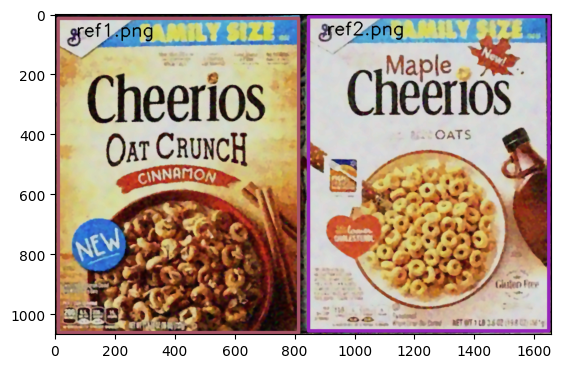

Scene image scene2.png
   Item found ref5.png: [ position: (1528.124, 450.316), width: 560.5250244140625 px, height: 843.9520263671875 px ]
   Item found ref3.png: [ position: (305.798, 493.382), width: 604.7420043945312 px, height: 941.35498046875 px ]
   Item found ref4.png: [ position: (927.171, 482.002), width: 634.2369995117188 px, height: 950.947998046875 px ]


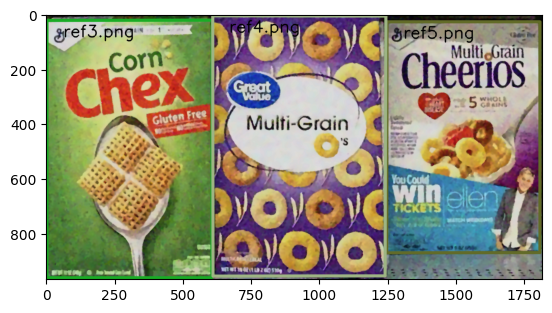

Scene image scene3.png
   Item found ref6.png: [ position: (299.574, 458.702), width: 601.3060302734375 px, height: 671.7230224609375 px ]
   Item found ref7.png: [ position: (889.174, 461.081), width: 543.291015625 px, height: 650.5 px ]
   Item found ref8.png: [ position: (1446.971, 398.319), width: 558.77001953125 px, height: 779.9429931640625 px ]


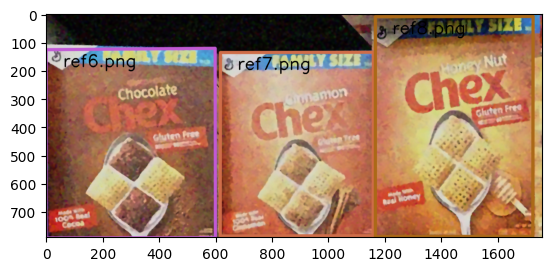

Scene image scene4.png
   Item found ref1.png: [ position: (887.003, 913.999), width: 382.0 px, height: 514.5750122070312 px ]
   Item found ref8.png: [ position: (350.591, 257.805), width: 349.3370056152344 px, height: 491.2460021972656 px ]
   Item found ref9.png: [ position: (175.109, 942.67), width: 329.00799560546875 px, height: 464.6470031738281 px ]


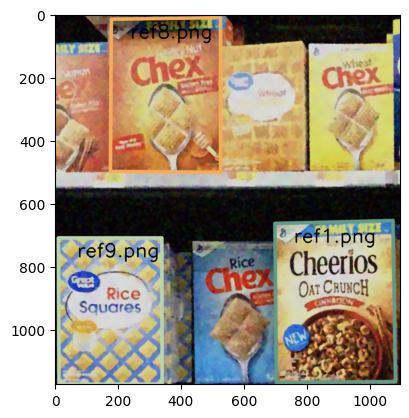

Scene image scene5.png
   Item found ref11.png: [ position: (369.014, 751.918), width: 367.135986328125 px, height: 554.593994140625 px ]
   Item found ref12.png: [ position: (715.738, 740.926), width: 439.56201171875 px, height: 661.3679809570312 px ]


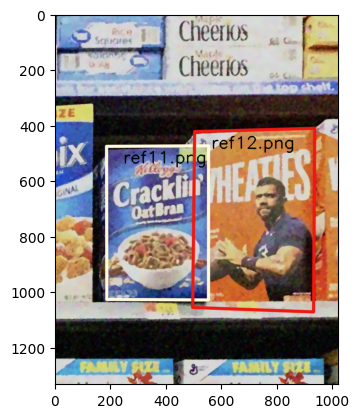

In [25]:
track_A_min_match_count = 60
find_items_in_scene_images(track_A_min_match_count, track_A_reference_images, track_A_scene_images, lambda_matcher, lambda_homography, find_items_in_scene_image_track_A)

# Track B Resolution
To address Track B, I extended the algorithm initially designed for Track A. Initially, my plan was to take the items found in Track A and apply a template matching algorithm to each of them in the scene image. However, I decided on a different strategy.

* For each scene image
 1. I gather all reference images that match within the scene image based on the Track A algorithm.
 2. I **overlay the bounding boxes** of these matched reference images onto the scene image, filling them with *white pixels*.
 3. I repeat the process from step 1.
 4.  This iteration continues until no reference image is matched within the scene image.

 This iterative process allows for a comprehensive resolution of Track B, allowing for the same reference image to be identified and matched within the scene image multiple times.

The method `compute_new_scene_image` computes a new scene image by overlaying the bounding boxes of matched reference images onto the scene image based on the transformation matrices obtained during the matching process.

In [26]:
def compute_new_scene_image(scene_image, items_found):
    h_scene, w_scene, _ = scene_image.shape
    new_scene_image = scene_image.copy()
    # Iterate over each item found in the scene
    for idx, item_found in items_found.iterrows():
        # Extract transformation matrix and reference image shape
        M = item_found['M']
        h_ref, w_ref = item_found['ref_shape']
        # Create a white template image with the same shape as the reference image
        white = np.ones([h_ref, w_ref, 3], dtype=np.uint8) * 255
        # Warp the white template using the transformation matrix to match the scene image
        warped = cv2.warpPerspective(white, M, (w_scene, h_scene))
        # Identify black pixels in the warped image
        black_pixels = np.equal(warped, np.array([0, 0, 0]))
        # Restore original pixel values from the scene image
        warped[black_pixels] = new_scene_image[black_pixels]
        # Update the new scene image with the warped image
        new_scene_image = warped
    return new_scene_image

In [27]:
def find_items_in_scene_image_track_B(min_match_count, reference_images, scene_image, lambda_matcher, lambda_homography):
    scene_image_copy = scene_image.copy()
    # Initialize an empty DataFrame to store Track B items found
    track_B_items_found = pd.DataFrame(columns=items_found_cols)
    # Iteratively find items in the scene image until no more items are found
    while True:
        # Find items in the scene image using Track A algorithm
        track_A_items_found = find_items_in_scene_image_track_A(min_match_count, reference_images, scene_image_copy, lambda_matcher, lambda_homography)
        # If no items are found, exit the loop
        if len(track_A_items_found) == 0:
            break
        # Concatenate the newly found items with the existing Track B items found
        track_B_items_found = pd.concat([track_B_items_found, track_A_items_found], axis=0, ignore_index=True)
        # Update the scene image by masking the newly found items
        scene_image_copy = compute_new_scene_image(scene_image_copy, track_A_items_found)
    # Return the DataFrame containing all Track B items found
    return track_B_items_found

The `track_B_min_match_count` of 20 was selected because it facilitated matching the highest number of items. This value is significantly lower compared to Track A due to the increased blurriness of the scene images in Track B.

Scene image scene6.png
   Item found ref15.png: [ position: (582.848, 621.673), width: 325.4739990234375 px, height: 905.4719848632812 px ]
   Item found ref15.png: [ position: (188.234, 618.617), width: 339.7250061035156 px, height: 906.4879760742188 px ]
   Item found ref15.png: [ position: (934.813, 628.24), width: 343.4590148925781 px, height: 919.7310180664062 px ]


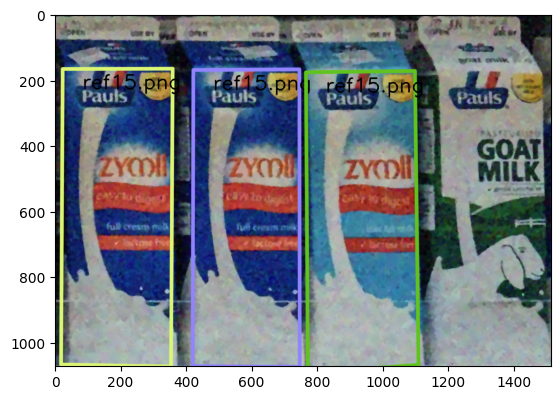

Scene image scene7.png
   Item found ref16.png: [ position: (794.626, 461.665), width: 216.06199645996094 px, height: 602.7050170898438 px ]
   Item found ref16.png: [ position: (1030.629, 462.129), width: 229.47000122070312 px, height: 603.6119995117188 px ]


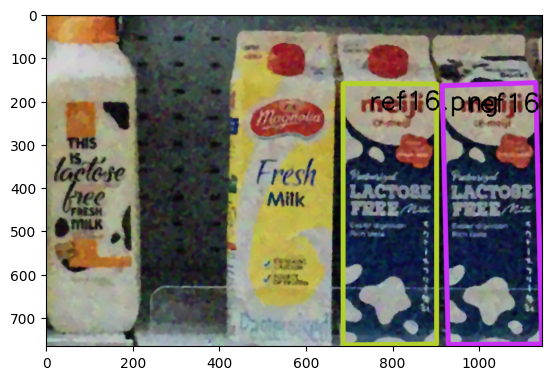

Scene image scene8.png
   Item found ref24.png: [ position: (1336.603, 583.427), width: 327.87298583984375 px, height: 867.8569946289062 px ]
   Item found ref17.png: [ position: (648.636, 568.342), width: 325.5719909667969 px, height: 854.447998046875 px ]
   Item found ref26.png: [ position: (263.005, 575.92), width: 386.3680114746094 px, height: 813.969970703125 px ]
   Item found ref23.png: [ position: (988.09, 567.401), width: 323.9989929199219 px, height: 870.2440185546875 px ]


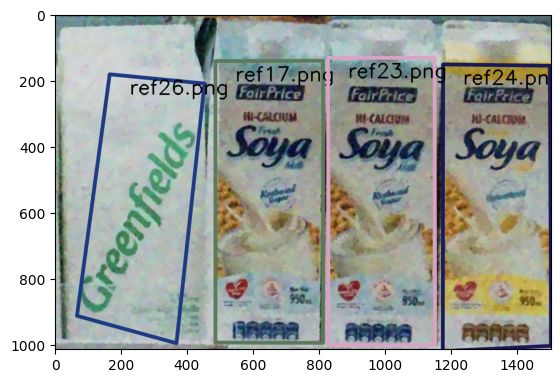

Scene image scene9.png
   Item found ref19.png: [ position: (850.843, 376.015), width: 223.41600036621094 px, height: 567.1409912109375 px ]
   Item found ref20.png: [ position: (1105.582, 370.764), width: 231.22999572753906 px, height: 555.4910278320312 px ]
   Item found ref19.png: [ position: (619.366, 374.046), width: 225.58200073242188 px, height: 557.1640014648438 px ]
   Item found ref20.png: [ position: (1361.386, 377.412), width: 230.03900146484375 px, height: 555.6370239257812 px ]


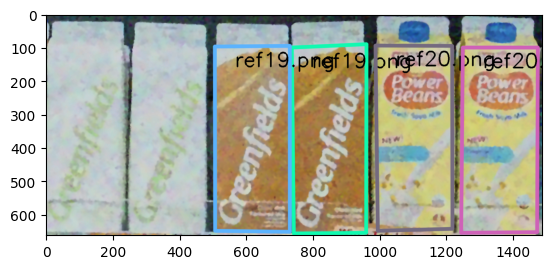

Scene image scene10.png
   Item found ref21.png: [ position: (981.445, 533.368), width: 247.14199829101562 px, height: 695.5659790039062 px ]
   Item found ref22.png: [ position: (1527.941, 531.614), width: 257.2619934082031 px, height: 717.114013671875 px ]
   Item found ref21.png: [ position: (708.013, 531.539), width: 244.98199462890625 px, height: 701.3250122070312 px ]
   Item found ref22.png: [ position: (1262.564, 533.726), width: 250.03599548339844 px, height: 702.8250122070312 px ]


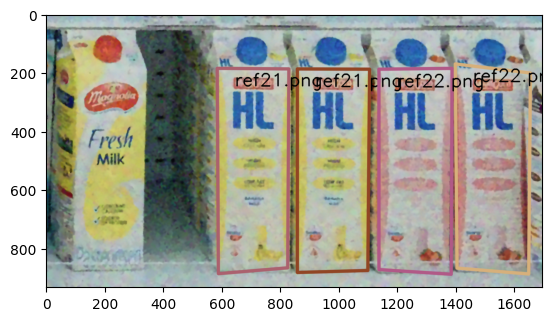

Scene image scene11.png
   Item found ref24.png: [ position: (555.127, 368.784), width: 186.35499572753906 px, height: 481.1059875488281 px ]
   Item found ref25.png: [ position: (1344.592, 371.417), width: 189.27099609375 px, height: 475.7959899902344 px ]
   Item found ref17.png: [ position: (167.979, 363.427), width: 186.8679962158203 px, height: 495.51300048828125 px ]
   Item found ref24.png: [ position: (745.615, 374.958), width: 190.11599731445312 px, height: 494.8080139160156 px ]
   Item found ref25.png: [ position: (1142.908, 370.831), width: 186.39999389648438 px, height: 482.8139953613281 px ]
   Item found ref17.png: [ position: (356.516, 366.379), width: 183.4669952392578 px, height: 481.364990234375 px ]
   Item found ref25.png: [ position: (942.206, 371.319), width: 195.38099670410156 px, height: 479.99200439453125 px ]


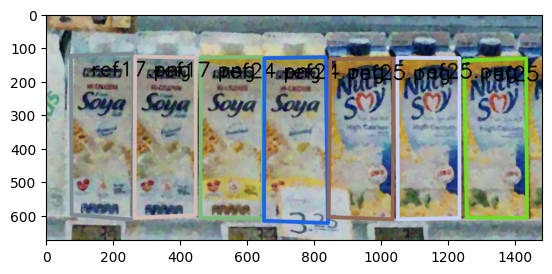

Scene image scene12.png
   Item found ref27.png: [ position: (409.048, 400.846), width: 248.41900634765625 px, height: 588.9949951171875 px ]
   Item found ref26.png: [ position: (138.073, 389.798), width: 241.39300537109375 px, height: 593.1420288085938 px ]


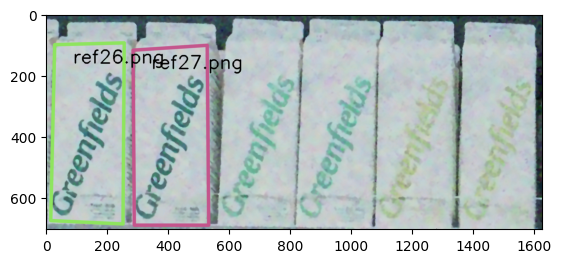

In [29]:
track_B_min_match_count = 20
find_items_in_scene_images(track_B_min_match_count, track_B_reference_images, track_B_scene_images, lambda_matcher, lambda_homography,find_items_in_scene_image_track_B)